In [1]:
import pandas as pd
import numpy as np
import openpyxl
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("manaus.csv", sep=";", low_memory=False)
raw_data.head()

,_dt_evolucao,_dt_notificacao,_dt_sintomas,_classificacao,_conclusao,_origem,_comorb_cardio,_comorb_cromossomica,_comorb_diabetes,_comorb_hemato,...,_sintoma_tosse,_sintoma_outros,_srag,_teste_anticorpo,_teste_antigeno,_teste_pcr,_bairro,_bairro_mapa,_distrito,_taxa
0,25/01/2020 00:00,03/01/2020 00:00,01/01/2020 00:00,Descartado,Recuperado,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,TARUMA,TARUMÃ,OESTE,"0,243042897"
1,03/01/2020 00:00,03/01/2020 00:00,01/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,Influenza B,NaN,NaN,NaN,TARUMA-ACU,TARUMÃ-AÇÚ,OESTE,"0,684931507"
2,05/01/2020 00:00,03/01/2020 00:00,03/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,JORGE TEIXEIRA,JORGE TEIXEIRA,LESTE,"0,073137374"
3,16/01/2020 00:00,08/01/2020 00:00,04/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,FLORES,FLORES,SUL,"0,198306463"
4,11/01/2020 00:00,08/01/2020 00:00,05/01/2020 00:00,Descartado,Recuperado,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,CIDADE DE DEUS,CIDADE DE DEUS,NORTE,"0,117699678"


In [3]:
df_confirmed = raw_data[raw_data['_classificacao'] == 'Confirmado']
df_confirmed.head()

,_dt_evolucao,_dt_notificacao,_dt_sintomas,_classificacao,_conclusao,_origem,_comorb_cardio,_comorb_cromossomica,_comorb_diabetes,_comorb_hemato,...,_sintoma_tosse,_sintoma_outros,_srag,_teste_anticorpo,_teste_antigeno,_teste_pcr,_bairro,_bairro_mapa,_distrito,_taxa
130,02/03/2020 00:00,23/02/2020 00:00,15/02/2020 00:00,Confirmado,Recuperado,"SIVEP, GAL",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,1.0,MAUAZINHO,MAUAZINHO,LESTE,"0,35040998"
144,01/03/2020 00:00,28/02/2020 00:00,26/02/2020 00:00,Confirmado,Recuperado,"SIVEP, GAL",NaN,NaN,NaN,NaN,...,Sim,Sim,Vírus Sincicial Respiratório,NaN,NaN,1.0,NOVO ALEIXO,NOVO ALEIXO,NORTE,"0,085452557"
153,05/04/2020 00:00,02/03/2020 00:00,23/02/2020 00:00,Confirmado,Recuperado,"SIVEP, eSUS VE,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,1.0,NaN,NaN,PRACA 14 DE JANEIRO,PRAÇA 14 DE JANEIRO,SUL,"0,861920359"
158,14/03/2020 00:00,02/03/2020 00:00,29/02/2020 00:00,Confirmado,Recuperado,"SIVEP, eSUS VE,",Sim,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,2.0,NaN,NaN,FLORES,FLORES,SUL,"0,198306463"
196,14/03/2020 00:00,11/03/2020 00:00,09/03/2020 00:00,Confirmado,Recuperado,"SIVEP, GAL",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,2.0,CIDADE NOVA,CIDADE NOVA,NORTE,"0,068152389"


## 2.1-1.Quantos atributos descrevem cada exemplo? Quais são eles?

In [4]:
quantity_attributes = df_confirmed.shape[1]
print(f'Dataframe possui {quantity_attributes} atributos.')

Dataframe possui 39 atributos.


In [5]:
attributes = []
for att in df_confirmed.columns:
    attributes.append(att)

print(f'Lista com todos atributos {attributes}')


Lista com todos atributos ['_dt_evolucao', '_dt_notificacao', '_dt_sintomas', '_classificacao', '_conclusao', '_origem', '_comorb_cardio', '_comorb_cromossomica', '_comorb_diabetes', '_comorb_hemato', '_comorb_hepatica', '_comorb_imuno', '_comorb_neurologica', '_comorb_obessidade', '_comorb_renal', '_comorb_respiratoria', '_criterio', '_etnia', '_evolução', '_idade', '_faixa etária', '_gestante', '_profiss_saude', '_raca', '_se_notificacao', '_sexo', '_sintoma_dispneia', '_sintoma_febre', '_sintoma_garganta', '_sintoma_tosse', '_sintoma_outros', '_srag', '_teste_anticorpo', '_teste_antigeno', '_teste_pcr', '_bairro', '_bairro_mapa', '_distrito', '_taxa']


## 2.1-2.Quantos casos confirmados há em Manaus, cumulativamente?

In [6]:
confirmed_cases = df_confirmed.shape[0]
print(f'{confirmed_cases} casos confirmados em Manaus.')

80420 casos confirmados em Manaus.


## 2.1-3.A qual período de tempo a base de dados se refere, isto é, qual o registro mais antigo e qual o mais recente? Leve em conta a data de notificação.

In [7]:
#neighborhoods_duplicates.loc[neighborhoods_duplicates._quantidade == NaN, '_quantidade'] = df_amount['_quantidade']
df_confirmed.loc[:,'_dt_notificacao'] = pd.to_datetime(df_confirmed['_dt_notificacao'], format='%d/%m/%Y %H:%M')
df_confirmed_notification = pd.DataFrame(df_confirmed['_dt_notificacao'])

C:\Users\LudusLab\anaconda3\envs\rna\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
df_confirmed_notification.sort_values('_dt_notificacao', ascending=False, inplace=True)
df_confirmed_notification = df_confirmed_notification.dropna()

In [9]:
oldest_record = df_confirmed_notification.iloc[0]
latest_record = df_confirmed_notification.iloc[df_confirmed_notification.shape[0]-1]

In [10]:
print(f'Registro mais antigo é {oldest_record.values}')
print(f'Registro mais recente é {latest_record.values}')

Registro mais antigo é ['2020-12-29T00:00:00.000000000']
Registro mais recente é ['2020-02-16T00:00:00.000000000']


## Limpeza dos Dados

### Excluir atributos não relevantes

In [11]:
discarded_data = []
def clear_data():
    for att in attributes:
        if att != '_dt_notificacao' and att != '_classificacao' and att != '_conclusao' and att != '_criterio' and att != '_evolução' and att != '_idade' and att != '_faixa etária' and att != '_sexo' and att != '_teste_anticorpo' and att != '_teste_antigeno' and att != '_teste_pcr' and att != '_bairro' and att != '_taxa':
                discarded_data.append(att)

clear_data()

In [12]:
df_confirmed = df_confirmed.drop(discarded_data,axis=1)

### Excluir linhas de dados faltantes

### !O valor zero foi atribuído nas colunas dos testes que o paciente não realizou.!

In [13]:
df_confirmed['_teste_anticorpo'] = df_confirmed['_teste_anticorpo'].fillna(0)
df_confirmed['_teste_antigeno'] = df_confirmed['_teste_antigeno'].fillna(0)
df_confirmed['_teste_pcr']= df_confirmed['_teste_pcr'].fillna(0)

In [14]:
df_clean_data = df_confirmed.dropna()

In [15]:
df_clean_data

,_dt_notificacao,_classificacao,_conclusao,_criterio,_evolução,_idade,_faixa etária,_sexo,_teste_anticorpo,_teste_antigeno,_teste_pcr,_bairro,_taxa
130,2020-02-23,Confirmado,Recuperado,Laboratorial,Internado em UTI,12.0,10a - 14a,F,0.0,0.0,1.0,MAUAZINHO,"0,35040998"
144,2020-02-28,Confirmado,Recuperado,Laboratorial,Internado,39.0,30a - 39a,F,0.0,0.0,1.0,NOVO ALEIXO,"0,085452557"
153,2020-03-02,Confirmado,Recuperado,Laboratorial,Internado em UTI,2.0,1a - 4a,F,1.0,0.0,0.0,PRACA 14 DE JANEIRO,"0,861920359"
158,2020-03-02,Confirmado,Recuperado,Laboratorial,Internado em UTI,71.0,70a - 79a,F,2.0,0.0,0.0,FLORES,"0,198306463"
196,2020-03-11,Confirmado,Recuperado,Clínico,Internado,46.0,40a - 49a,F,0.0,0.0,2.0,CIDADE NOVA,"0,068152389"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14046,2020-12-15,Confirmado,Óbito,Laboratorial,Internado em UTI,60.0,60a - 69a,F,0.0,0.0,0.0,LAGO AZUL,"0,178428049"
14072,2020-12-28,Confirmado,Óbito,Laboratorial,Internado,70.0,70a - 79a,M,0.0,0.0,0.0,COROADO,"0,160758781"
14079,2020-12-15,Confirmado,Óbito,Laboratorial,Internado em UTI,75.0,70a - 79a,F,0.0,0.0,0.0,PARQUE 10 DE NOVEMBRO,"0,228326141"
14085,2020-12-23,Confirmado,Óbito por outras causas,Laboratorial,Internado,82.0,80a ou +,M,0.0,0.0,0.0,JORGE TEIXEIRA,"0,073137374"


## 1. Quantos exemplos e atributos há na base de dados após a limpeza e organização?

In [16]:
remaining_data = df_clean_data.shape[0]
print(f'A base de dados restante possui {remaining_data} registros.')

A base de dados restante possui 7645 registros.


In [17]:
remaining_data_att = df_clean_data.shape[1]
print(f'A base de dados restante possui {remaining_data_att} atributos.')

A base de dados restante possui 13 atributos.


## 2. Qual a porcentagem de indivíduos recuperados em relação ao todo?

In [18]:
recovered_patients = df_clean_data[df_clean_data['_conclusao'] == 'Recuperado'].shape[0]
total_patients = df_clean_data.shape[0]

In [19]:
percentage_recovered_patients = (recovered_patients/total_patients)*100
percentage_recovered_patients = np.round(percentage_recovered_patients, 3)

In [20]:
print(f'A porcentagem de indivíduos recuperados é de {percentage_recovered_patients}%.')

A porcentagem de indivíduos recuperados é de 58.496%.


## 3. Os casos acometeram mais indivíduos do sexo masculino ou feminino?

In [21]:
count_F = df_clean_data.groupby(['_sexo']).size()['F']
count_M = df_clean_data.groupby(['_sexo']).size()['M']
print("Sexo Feminino" if count_F > count_M else "Sexo Masculino")

Sexo Masculino


## 4.1 Qual a média e desvio padrão de idade dos indivíduos que contraíram COVID-19? 

In [22]:
individuals_age = df_clean_data['_idade']
individuals_age_mean = np.mean(individuals_age)
individuals_age_std = np.std(individuals_age)

In [23]:
print(f'Média de idades dos indivíduos é {round(individuals_age_mean,2)} anos.')
print(f'O desvio padrão de idades dos indivíduos é {round(individuals_age_std,2)}.')

Média de idades dos indivíduos é 56.29 anos.
O desvio padrão de idades dos indivíduos é 20.83.


## 4.2 Qual o indivíduo mais jovem e o mais idoso a contraírem tal enfermidade?

In [24]:
df_age = pd.DataFrame(df_clean_data)
df_age.sort_values('_idade', inplace=True, ascending=True)
older_individual = df_age.iloc[df_age.shape[0] - 1]
younger_individual = df_age.iloc[0]

In [25]:
print(f'O indivíduo mais idoso a contrair a enfermidade: {older_individual}')
print(f'O indivíduo mais jovem a contrair a enfermidade: {younger_individual}')

O indivíduo mais idoso a contrair a enfermidade: _dt_notificacao     2020-05-07 00:00:00
_classificacao               Confirmado
_conclusao                        Óbito
_criterio                  Laboratorial
_evolução                     Internado
_idade                            106.0
_faixa etária                  80a ou +
_sexo                                 F
_teste_anticorpo                    0.0
_teste_antigeno                     0.0
_teste_pcr                          1.0
_bairro                 SANTO AGOSTINHO
_taxa                       0,497537191
Name: 2766, dtype: object
O indivíduo mais jovem a contrair a enfermidade: _dt_notificacao     2020-07-27 00:00:00
_classificacao               Confirmado
_conclusao                   Recuperado
_criterio                  Laboratorial
_evolução                     Internado
_idade                              0.0
_faixa etária                      < 1a
_sexo                                 F
_teste_anticorpo                    

## 5. Qual o bairro com maior incidência de casos?

In [26]:
neighborhoods = pd.DataFrame(df_clean_data['_bairro'])
neighborhoods

,_bairro
130,MAUAZINHO
144,NOVO ALEIXO
153,PRACA 14 DE JANEIRO
158,FLORES
196,CIDADE NOVA
...,...
14046,LAGO AZUL
14072,COROADO
14079,PARQUE 10 DE NOVEMBRO
14085,JORGE TEIXEIRA


### Criei padrões regex para cada letra com acentos(a, e, i, o, u e ç), passei como parâmetro para uma função que busca o padrão desejado e qual deve ser o caractere para substituição, utilizando a compressão de lista para percorrer cada lista gerada a cada letra limpa.

In [27]:
def clear_data(data, pattern, sub):
    pattern_letter = re.compile(pattern)

    result = re.sub(pattern_letter, sub, data, 5)
    return result

In [28]:
raw_neighborhoods = neighborhoods['_bairro']
clear_a = [clear_data(x, r"^[áàâã]$", "a") for x in raw_neighborhoods]
clear_e = [clear_data(x, r"^[éê]$", "e") for x in clear_a]
clear_i = [clear_data(x, r"^[í]$", "i") for x in clear_e]
clear_o = [clear_data(x, r"^[óôòõ]$", "o") for x in clear_i]
clear_u = [clear_data(x, r"^[ú]$", "u") for x in clear_o]
clear_c = [clear_data(x, r"^[ç]$", "c") for x in clear_u]
df_neighborhoods_clean = pd.DataFrame(clear_c, columns = ["_bairro"])

In [29]:
df_neighborhoods_clean.value_counts()

_bairro               
CIDADE NOVA               480
COMPENSA                  321
JORGE TEIXEIRA            300
ALVORADA                  281
CENTRO                    264
                         ... 
PARQUE DEZ DE NOVEMBRO      1
PARQUE RIACHUELO II         1
PARQUE SAO PEDRO            1
PQ DAS LARANJEIRAS          1
JESUS ME DEU                1
Length: 147, dtype: int64

In [30]:
print('Bairro com maior incidência de casos é CIDADE NOVA')

Bairro com maior incidência de casos é CIDADE NOVA


## 6 - Quais os três bairros com maior incidência de casos recuperados?

In [31]:
select = df_clean_data._conclusao == 'Recuperado'
recovered = df_clean_data[select]
type(recovered)

pandas.core.frame.DataFrame

In [32]:
recovered._bairro.value_counts()
print(f'Três bairros com maior incidência de casos recuperados são: CIDADE NOVA, JORGE TEIXEIRA E COMPENSA.')

Três bairros com maior incidência de casos recuperados são: CIDADE NOVA, JORGE TEIXEIRA E COMPENSA.


## 7. Quais os tipos de testes efetuados, segundo os dados? Indique os dados de maneira quantitativa e percentual.

In [33]:
print('Foram realizados testes do tipo: anticorpo, antigeno e pcr.')

Foram realizados testes do tipo: anticorpo, antigeno e pcr.


In [34]:
antibody = df_clean_data._teste_anticorpo.sum()

In [35]:
antigen = df_clean_data._teste_antigeno.sum()

In [36]:
pcr = df_clean_data._teste_pcr.sum()

In [37]:
print(f'Quantitativa\nTeste Anticorpo: {antibody},\nTeste Antigeno: {antigen},\nTeste PCR: {pcr}.')

Quantitativa
Teste Anticorpo: 134.0,
Teste Antigeno: 37.0,
Teste PCR: 3849.0.


In [38]:
total_tests = antibody + antigen + pcr

In [39]:
print(f'Percentual\nTeste Anticorpo: {round((antibody/total_tests)*100,2)}%,\nTeste Antigeno: {round((antigen/total_tests)*100,2)}%,\nTeste PCR: {round((pcr/total_tests)*100,2)}%.')

Percentual
Teste Anticorpo: 3.33%,
Teste Antigeno: 0.92%,
Teste PCR: 95.75%.


## 8. Qual taxa de letalidade pode ser calculada a partir do conjunto de dados? Para calcular esta taxa, considere a fração do total de óbitos pelo total de casos

In [40]:
lista = pd.Series(df_clean_data._taxa)
lista = lista.apply(lambda x: x.replace(',', '.'))
df_clean_data.loc[df_clean_data._taxa != np.nan, '_taxa'] = lista

C:\Users\LudusLab\anaconda3\envs\rna\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [41]:
selection = df_clean_data._conclusao == 'Óbito'
death_rates = df_clean_data[selection]._taxa
df_death_rates = pd.DataFrame(death_rates)
df_death_rates['_taxa'] = pd.to_numeric(df_death_rates['_taxa'])

In [42]:
lethal_rate = df_death_rates.shape[0]/df_clean_data.shape[0]
print(f'Taxa de letalidade calculada a partir do conjunto de dados: {round(lethal_rate*100, 2)}%.')

Taxa de letalidade calculada a partir do conjunto de dados: 40.8%.


## 9. Qual o tipo de correlação, mediante coeficiente de correlação de Pearson, entre a idade e o número de casos? Para responder a esta pergunte, agrupe o número de casos por idade e efetue o cálculo de tal coeficiente. Indique, a partir do resultado, a natureza desta correlação, se é positiva ou negativa, e qual sua intensidade.

In [43]:
df_idade = pd.DataFrame(df_clean_data.groupby('_idade')[['_idade']].count())
df_idade.rename(columns={'_idade': 'contagem'}, inplace = True)
df_idade.rename_axis('idade')

,contagem
idade,
0.0,107
1.0,69
2.0,35
3.0,25
4.0,16
...,...
98.0,8
99.0,3
100.0,1


In [44]:
df_idade['idades'] = df_idade.index
correlacao = df_idade.idades.corr(df_idade.contagem)

In [45]:
print(f'Correlação positiva desprezível: {round(correlacao,2)}.')

Correlação positiva desprezível: 0.24.


# Visualização de Dados

## 1. Construa um histograma denotando a quantidade de casos nos 10 bairros em que houve mais casos registrados. Inclua todos os bairros remanescentes em uma categoria denominada “Outros.” Denote as informações de maneira percentual;

In [171]:
df_contagem = pd.DataFrame(df_neighborhoods_clean.value_counts(), columns=['contagem'])

In [172]:
df_temp = pd.DataFrame(df_contagem.index.values, columns=["bairros"])
df_contagem.index = range(df_contagem.shape[0])

In [173]:
df_temp['bairros'] = df_temp['bairros'].apply(lambda x: x[:][0])

In [174]:
df_contagem['bairros'] = df_temp['bairros']
df_dez_bairros = df_contagem.loc[:9]
soma = df_contagem.loc[10:, 'contagem'].sum()
df_dez_bairros

,contagem,bairros
0,480,CIDADE NOVA
1,321,COMPENSA
2,300,JORGE TEIXEIRA
3,281,ALVORADA
4,264,CENTRO
5,264,SAO JOSE OPERARIO
6,248,NOVO ALEIXO
7,225,PARQUE 10 DE NOVEMBRO
8,220,COROADO
9,219,PETROPOLIS


In [175]:
df_dez_bairros.loc[-1] = [soma, "OUTROS"]
df_dez_bairros.index = df_dez_bairros.index + 1  # shifting index
df_dez_bairros = df_dez_bairros.sort_index()
df_dez_bairros

C:\Users\LudusLab\anaconda3\envs\rna\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,contagem,bairros
0,4823,OUTROS
1,480,CIDADE NOVA
2,321,COMPENSA
3,300,JORGE TEIXEIRA
4,281,ALVORADA
5,264,CENTRO
6,264,SAO JOSE OPERARIO
7,248,NOVO ALEIXO
8,225,PARQUE 10 DE NOVEMBRO
9,220,COROADO


<AxesSubplot:xlabel='contagem', ylabel='Count'>

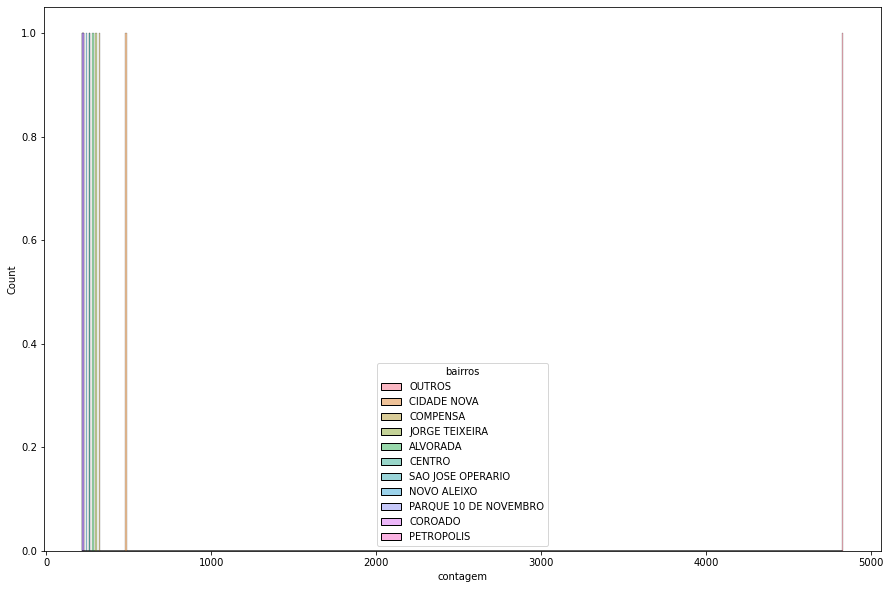

In [176]:
plt.figure(figsize=[15,10])
sns.histplot(data=df_dez_bairros, x="contagem", hue="bairros", bins=10, binwidth=10)
